In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns
import warnings
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports

from esio import EsioData as ed
from esio import import_data
from esio import ice_plot

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
E = ed.EsioData.load()
# Directories
all_models=['modcansipns_3', 'modcansipns_4']
runType='forecast'
updateall = False

In [4]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [5]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

In [6]:
## TODO
# - Get mask
# - Get lat lon bounds 

In [7]:
var_dic = {'longitude':'lon','latitude':'lat'}

In [8]:
# Option to shift time stamp from begining of month to end
monthly_in = {'modcansipns_3':True, 'modcansipns_4':True}

In [9]:
for model in all_models:
    print('Regridding ', model, '...')
    
    data_dir = E.model[model][runType]['native']
    data_out = E.model[model][runType]['sipn_nc']
    model_grid_file = E.model[model]['grid']
    
    # Files are stored as one per month, average of ensemble
    prefix = 'sic_monthly'
    all_files = sorted(glob.glob(os.path.join(data_dir, prefix+'*.nc'), recursive=True))

    print("Found ",len(all_files)," files.")
    if updateall:
        print("Updating all files...")
    else:
        print("Only updating new files")

    weights_flag = False # Flag to set up weights have been created

    # Load land/sea mask file
    if os.path.basename(model_grid_file)!='MISSING':
        ds_mask = xr.open_mfdataset(model_grid_file)
    else:
        ds_mask = None

    for cf in all_files:
        # Check if already imported and skip (unless updateall flag is True)
        f_out = os.path.join(data_out, os.path.basename(cf).split('_grid_')[1]+'_Stereo.nc') # netcdf file out 
        if not updateall:
            # TODO: Test if the file is openable (not corrupted)
            if os.path.isfile(f_out):
                print("Skipping ", os.path.basename(cf), " already imported.")
                continue # Skip, file already imported

        drop_vars = ['time_bnd', 'institution', 'experiment_id', 'source', 'realization', 'sc']
        ds = xr.open_mfdataset(cf, drop_variables=drop_vars, 
                     preprocess=lambda x: import_data.preprocess_time_monthly_Cansips(x))
        
        # Shift time stamp to middle of month
        if monthly_in[model]:
            print("shifting monthly time stamp to middle of month")
            ds.coords['init_time'] = ds.init_time + np.timedelta64(15, 'D')
        
        # Rename variables per esipn guidelines
        ds.rename(var_dic, inplace=True);

        # Apply masks (if available)
        if ds_mask:
            print('found mask')
            # land_mask is the fraction of native grid cell that is land
            # (1-land_mask) is fraction ocean
            # Multiply sic by fraction ocean to get actual native grid cell sic
            # Also mask land out where land_mask==1
            ds = ds * (1 - ds_mask.land_mask.where(ds_mask.land_mask<1))

        # Calculate regridding matrix
        regridder = xe.Regridder(ds, obs_grid, method, periodic=False, reuse_weights=weights_flag)
        weights_flag = True # Set true for following loops

        # Add NaNs to empty rows of matrix (forces any target cell with ANY source cells containing NaN to be NaN)
        if method=='conservative':
            regridder = import_data.add_matrix_NaNs(regridder)

        # Regrid variables
        var_list = []
        for cvar in ds.data_vars:
            var_list.append(regridder(ds[cvar]))
        ds_out = xr.merge(var_list)

        # Expand dims
        ds_out = import_data.expand_to_sipn_dims(ds_out)

        # # Save regridded to netcdf file
        ds_out.to_netcdf(f_out)
        ds_out = None # Memory clean up
        ds = None
        print('Saved ', f_out)
        

Regridding  modcansipns_3 ...
Found  192  files.
Only updating new files
Skipping  sic_monthly_CCCma-CanCM3_NEW_OPER_original_grid_i20130401.nc  already imported.
Skipping  sic_monthly_CCCma-CanCM3_NEW_OPER_original_grid_i20130501.nc  already imported.
Skipping  sic_monthly_CCCma-CanCM3_NEW_OPER_original_grid_i20130601.nc  already imported.
shifting monthly time stamp to middle of month
Create weight file: nearest_s2d_64x128_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/modcansipns_3/forecast/sipn_nc/i20130701.nc_Stereo.nc
shifting monthly time stamp to middle of month
Reuse existing file: nearest_s2d_64x128_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/modcansipns_3/forecast/sipn_nc/i20130801.nc_Stereo.nc
Skipping  sic_monthly_CCCma-CanCM3_NEW_OPER_original_grid_i20140401.nc  already imported.
Skipping  sic_monthly_CCCma-CanCM3_NEW_OPER_original_grid_i20140501.nc  already imported.
Skipping  sic_monthly_CCCma-CanCM3_NEW_OPER_original_grid_i20140601.nc  already imported.
sh

In [10]:
# Clean up
if weights_flag:
    regridder.clean_weight_file()  # clean-up

# Plotting

AttributeError: 'NoneType' object has no attribute 'sic'

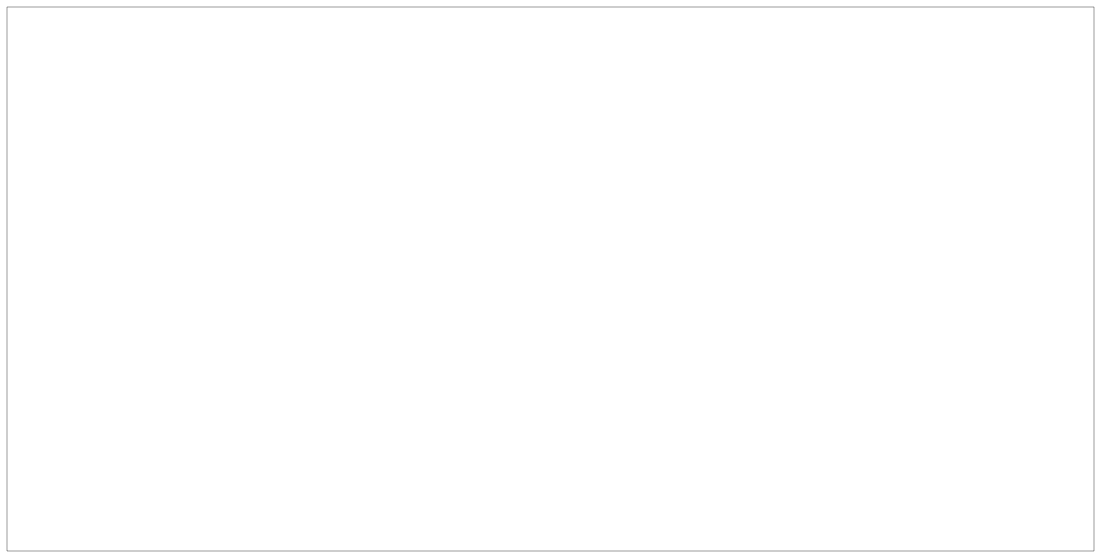

In [11]:
sic_all = xr.open_mfdataset(f_out)
sic_all

# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'red')

# Plot original projection
plt.figure(figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
ds_p = ds.sic.isel(fore_time=8).isel(ensemble=0)
ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                 vmin=0, vmax=1,
                                 cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)),
                    transform=ccrs.PlateCarree());
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

# Plot SIC on target projection
(f, ax1) = ice_plot.polar_axis()
ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Original Grid')

# Plot SIC on target projection
(f, ax1) = ice_plot.polar_axis()
ds_p2 = sic_all.sic.isel(init_time=0).isel(fore_time=8).isel(ensemble=0)
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Target Grid')
